In [ ]:
import os
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

In [2]:
# HYPERPARAMETERS
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 100
NOISE_SIZE = 100

Part 1: Create Grumpy Cat Dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dir, transform = transforms.ToTensor()):
        self.total_imgs: list[torch.Tensor] = []
        for file in os.listdir(dir):
            self.total_imgs.append( Image.open(dir + '/' + file) )
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.total_imgs)
    
    def __getitem__(self, idx) -> Image.Image:
        return self.transform(self.total_imgs[idx])

Part 2: Data Augmentation

In [4]:
def get_transform(mode: str) -> nn.Module:
    if mode == "simple":
        return transforms.Compose([
            transforms.Resize((64, 64), transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif mode == "deluxe":
        return transforms.Compose([
            transforms.Resize((64, 64), transforms.InterpolationMode.BICUBIC),
            transforms.RandomGrayscale(0.2),
            transforms.RandomRotation(180),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    raise NotImplementedError

Part 3: Implement the Discriminator of the DCGAN

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # size_out = (size_in + 2 * padding - kernel) / stride + 1
        self.layers = nn.Sequential(
            # INPUT 3x64x64
            nn.Conv2d(  3,  32, kernel_size=4, stride=2, padding=1), # 32x32x32
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d( 32,  64, kernel_size=4, stride=2, padding=1), # 64x16x16
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d( 64, 128, kernel_size=4, stride=2, padding=1), # 128x8x8
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 256x4x4
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=6, stride=2, padding=1), # 1x1x1
        )
    
    def forward(self, z) -> torch.Tensor:
        return self.layers(z).squeeze()

Part 4: Implement the Generator of the DCGAN

In [6]:
class Generator(nn.Module):
    def __init__(self, noise_size=100):
        super(Generator, self).__init__()
        # size_out = (size_in - 1) * stride - 2 * padding + kernel
        self.layers = nn.Sequential(
            # INPUT nsx1x1
            nn.ConvTranspose2d(noise_size, 256, kernel_size=6, stride=2, padding=1),    # 256x4x4
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),           # 128x8x8
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),            # 64x16x16
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 32, kernel_size=4, stride=2, padding=1),            # 32x32x32
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d( 32,  3, kernel_size=4, stride=2, padding=1),            # 3x64x64
            nn.Tanh(),
        )
    
    def forward(self, z) -> torch.Tensor:
        return self.layers(z)

Part 5: Training Loop

In [7]:
def training_loop(dataset: Dataset):
    # Create generators and discriminators
    generator = Generator(NOISE_SIZE)
    discriminator = Discriminator()

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    D_losses = []
    G_losses = []
    for _ in range(NUM_EPOCHS):
        iteration = 0 
        total_loss = [0,0] # total discriminator and generator loss of current epoch
        for data in dataloader:
            n = data.shape[0]
            # 
            # TRAIN DISCRIMINATOR
            # 
            
            d_optimizer.zero_grad()

            # 1. Compute the discriminator loss on real images
            D_real_pred: torch.Tensor = discriminator(data)
            D_real_loss: torch.Tensor = (1 - D_real_pred).pow(2)

            # 2. Sample noise
            noise: torch.Tensor = torch.rand((n,NOISE_SIZE,1,1))

            # 3. Generate fake images from the noise
            fake_images: torch.Tensor = generator(noise)

            # 4. Compute the discriminator loss on the fake images
            D_fake_pred: torch.Tensor = discriminator(fake_images)
            D_fake_loss: torch.Tensor = (-1 - D_fake_pred).pow(2)

            # 5. Compute total loss
            D_total_loss: torch.Tensor = (D_real_loss + D_fake_loss).sum().div(n)
            if iteration % 2 == 0:
                D_total_loss.backward()
                d_optimizer.step()

            # 
            # TRAIN GENERATOR
            # 

            g_optimizer.zero_grad()

            # 1. Sample noise
            noise: torch.Tensor = torch.rand((n,NOISE_SIZE,1,1))

            # 2. Generate fake images from the noise
            fake_images: torch.Tensor = generator(noise)

            # 3. Compute the generator loss
            D_gen_pred: torch.Tensor = discriminator(fake_images)
            G_loss: torch.Tensor = (1 - D_gen_pred).pow(2).sum().div(n)

            G_loss.backward()
            g_optimizer.step()

            # Print each loss every 200 iterations
            # if iteration % 200 == 0:
            #     print(f"Loss - Discriminator: {D_total_loss:<8.2f} Generator: {G_loss:<8.2f}")
            iteration += 1

            total_loss[0] += D_total_loss.item()
            total_loss[1] += G_loss.item()
        D_losses.append(total_loss[0])
        G_losses.append(total_loss[1])
    
    return D_losses, G_losses

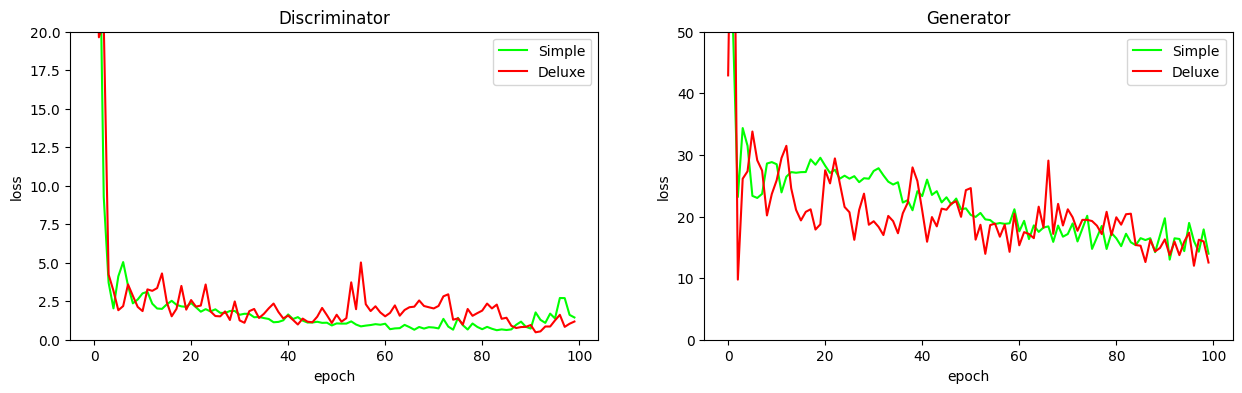

In [ ]:
dataset = CustomDataset("grumpifyCat")
# simple transformation
dataset.transform = get_transform("simple")
simple_losses = training_loop(dataset)
# deluxe transformation
dataset.transform = get_transform("deluxe")
deluxe_losses = training_loop(dataset)
# make plot
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].set_title("Discriminator")
ax[0].set(ylim=[0,20])
ax[1].set_title("Generator")
ax[1].set(ylim=[0,50])
for i in [0,1]:
    ax[i].plot(simple_losses[i], label="Simple", c="lime")
    ax[i].plot(deluxe_losses[i], label="Deluxe", c="red")
    ax[i].set(xlabel="epoch", ylabel="loss")
    ax[i].legend()
plt.show()